<a href="https://colab.research.google.com/github/saadashraf/DiffusedDG/blob/main/diffused_dg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Augmentation using Stable Diffusion for Better Generalization

## Requirements

In [10]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install numpy accelerate opencv-python pandas matplotlib ultralytics diffusers transformers datasets

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u2ubenrg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u2ubenrg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [118]:
import os
from PIL import Image

import torch
import numpy as np
from segment_anything import build_sam, SamPredictor
from ultralytics import YOLO
from diffusers import StableDiffusionInpaintPipeline

In [2]:
WORKING_DIR = os.getcwd()
WEIGHTS_DIRECTORY = os.path.join(WORKING_DIR, "weights")
ASSETS_DIRECTORY = os.path.join(WORKING_DIR, "assets")

In [3]:
if not os.path.exists(WEIGHTS_DIRECTORY):
    os.mkdir(WEIGHTS_DIRECTORY)

if not os.path.exists(ASSETS_DIRECTORY):
    os.mkdir(ASSETS_DIRECTORY)

In [117]:
!wget -nc -O "$WEIGHT_PATH" https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

File ‘/home/mdafifal.mamun/personal/projects/DiffusedDG/weights/sam_vit_h_4b8939.pth’ already there; not retrieving.


In [116]:
SEGMENTATION_MODEL_KEY = f"{WEIGHTS_DIRECTORY}/sam_vit_h_4b8939.pth"
DIFFUSION_MODEL_KEY = "stabilityai/stable-diffusion-2-inpainting"
DETECTION_MODEL_KEY = "yolov8s.pt"

## Load Dataset

In [6]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Cat_and_Dog")

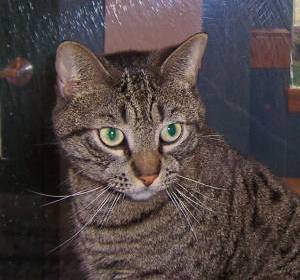

In [20]:
dataset["train"][0]["image"]

# Generator

In [122]:
from typing import Dict, List


class Generator:
    def __init__(self, detection_model: str, segmentation_model: str, diffusion_model: str, device: str = "cuda") -> None:
        self._detection_model = YOLO(detection_model)
        self._segmentation_model = SamPredictor(build_sam(checkpoint=segmentation_model).to(device))
        self._sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
            diffusion_model,
            torch_dtype=torch.float16 if device=="cuda" else torch.float32,
        ).to(device)
        self._device = device
    
    def detect(self, image: Image) -> List[Dict]:
        results = self._detection_model(image)

        # Extract bounding boxes, classes, names, and confidences
        boxes = results[0].boxes.xyxy.tolist()
        classes = results[0].boxes.cls.tolist()
        names = results[0].names
        confidences = results[0].boxes.conf.tolist()

        formatted_result = []

        # Iterate through the results
        for box, class_id, conf in zip(boxes, classes, confidences):
            name = names[int(class_id)]
            formatted_result.append(
                {"class": name, "class_id": class_id, "bbox": box, "confidence": conf}
            )

        return formatted_result

    def segment(self, image: Image, boxes: List):
        image_np = np.asarray(image)
        self._segmentation_model.set_image(image_np)
        H, W, _ = image_np.shape
        boxes_xyxy = torch.as_tensor(boxes)

        transformed_boxes = self._segmentation_model.transform.apply_boxes_torch(boxes_xyxy.to(self._device), image_np.shape[:2])
        masks, _, _ = self._segmentation_model.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
            )
        return masks.cpu()

    def draw_mask(self, mask, image, random_color=True) -> np.array:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.2])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

        annotated_frame_pil = image.convert("RGBA")
        mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

        return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

    def generate_image(self, image: Image, prompt: str, negative_prompt: str, seed: int = 42, inverted: bool = True) -> Dict:
        detection_result = self.detect(image)
        detected_boxes = [det["bbox"] for det in detection_result]
        segmented_frame_masks = self.segment(image, boxes=detected_boxes)
        annotated_frame_with_mask = self.draw_mask(segmented_frame_masks[0][0], image)
        
        mask = segmented_frame_masks[0][0].cpu().numpy()
        inverted_mask = ((1 - mask) * 255).astype(np.uint8)
        mask = Image.fromarray(mask)
        inverted_mask = Image.fromarray(inverted_mask)


        # resize for inpainting
        w, h = image.size
        in_image = image.resize((512, 512))
        in_mask = inverted_mask.resize((512, 512)) if inverted else mask.resize((512, 512))

        generator = torch.Generator(self._device).manual_seed(seed)

        sd_result = self._sd_pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
        sd_result = sd_result.images[0]

        results = {
            "detection_result": detection_result,
            "mask": in_mask,
            "annotated_frame_mask": annotated_frame_with_mask,
            "generated_image": sd_result.resize((w, h)),
        }

        return results


In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [124]:
gen = Generator(
    detection_model=DETECTION_MODEL_KEY, 
    segmentation_model=SEGMENTATION_MODEL_KEY, 
    diffusion_model=DIFFUSION_MODEL_KEY, 
    device=device
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [128]:
sample_image = dataset["train"][580]["image"]

In [133]:
result = gen.generate_image(sample_image, "mountains landscape", "low resolution, ugly", -1, True)


0: 512x640 3 cats, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


  0%|          | 0/50 [00:00<?, ?it/s]

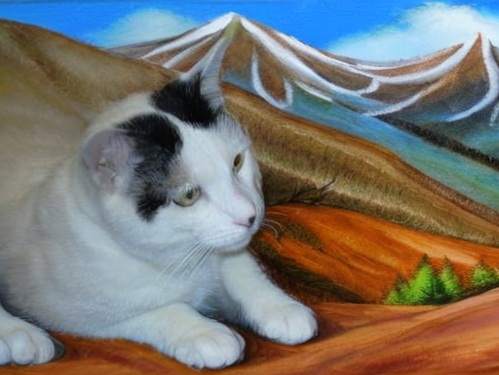

In [134]:
result["generated_image"]